# 쇼핑 모델링 6개월 

## 라이브러리 호출

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#한글폰트 가져오기
from matplotlib import rc
rc('font', family='NanumGothic')

# Warning 메세지를 뜨지 않게 해줌
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler, StandardScaler

#평가
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

## 데이터 불러오기

In [2]:
train = pd.read_csv('./Online Retail_2009.csv')
test = pd.read_csv('./2010_final.csv')

In [3]:
# test 2011년 5월 30일 이전까지 사용
test = test[test['InvoiceDate'] <= '2011-05-30']

In [4]:
test = test.drop(columns='Unnamed: 0')


In [5]:
train.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 391893 entries, 0 to 391892
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    391893 non-null  int64  
 1   StockCode    391893 non-null  object 
 2   Description  391893 non-null  object 
 3   Quantity     391893 non-null  int64  
 4   InvoiceDate  391893 non-null  object 
 5   UnitPrice    391893 non-null  float64
 6   CustomerID   391893 non-null  int64  
 7   Country      391893 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 23.9+ MB
<class 'pandas.core.frame.DataFrame'>
Index: 143971 entries, 0 to 143970
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    143971 non-null  int64  
 1   StockCode    143971 non-null  object 
 2   Description  143971 non-null  object 
 3   Quantity     143971 non-null  int64  
 4   InvoiceDate  143971 non-null 

## 디폴트 데이터
value: 구매여부
- pivot_CS: 구매여부를 추출하기 위한 데이터프레임
- pivot_test: 평가를 위한 데이터프레임
- pairs_CI: InvoiceNo_to_CustomerID함수 적용을 위한 데이터프레임
- pairs_SD: StockCode에 따른 Description을 출력하기 위한 데이터프레임

In [6]:
#pivot_CS
df_CS = pd.DataFrame(train.loc[:,['CustomerID','StockCode']].groupby('CustomerID').value_counts())
df_CS['count'] = 1
pivot_CS = df_CS.pivot_table('count', index='CustomerID',columns='StockCode')
pivot_CS.fillna(0,inplace=True)

#pivot_test
df_CS_test = pd.DataFrame(test.loc[:,['CustomerID','StockCode']].groupby('CustomerID').value_counts())
df_CS_test['count'] = 1
pivot_test = df_CS_test.pivot_table('count', index='CustomerID',columns='StockCode')
pivot_test.fillna(0,inplace=True)

#paris_CI 생성
pairs_CI = train[['CustomerID','InvoiceNo']].groupby('CustomerID')['InvoiceNo'].apply(lambda x: x.unique())

#paris_SD 생성
pairs_SD = train.loc[:,['StockCode','Description']].groupby('StockCode')['Description'].apply(lambda x: x.unique())

### 겹치는 StockCode 확인

In [7]:
print(len(train['StockCode'].unique()))
print(len(set(train['StockCode'].unique())))
print(len(test['StockCode'].unique()))
print(len(set(test['StockCode'].unique())))
print(len(set(train['StockCode'].unique()).intersection(set(test['StockCode'].unique()))))

4000
4000
3106
3106
2881


### 겹치는 CusomerID 확인

In [8]:
print(len(train['CustomerID'].unique()))
print(len(set(train['CustomerID'].unique())))
print(len(test['CustomerID'].unique()))
print(len(set(test['CustomerID'].unique())))
print(len(set(train['CustomerID'].unique()).intersection(set(test['CustomerID'].unique()))))

4239
4239
2706
2706
2040


## 함수생성

### InvoiceNo_to_CustomerID
InvoiceNo - StockCode 형태를 CustomerID - StockCode형태로 변환

In [7]:
def InvoiceNo_to_CustomerID(Pred_IS, pairs_CI = pairs_CI):
    #빈객체 생성
    merged_data = []
    CustomerID_list = []
    #CustomerID와 InvoiceNo를 각각 저장해 루프 생성
    for CustomerID, invoice_list in pairs_CI.items():
        #같은 CutomerID 예측 값만 추출해 저장
        customer_data = Pred_IS[Pred_IS.index.isin(invoice_list)] 
        merged_data.append(customer_data.mean(axis=0)) #값들을 모두 합해 새로운 객체에 저장
        CustomerID_list.append(CustomerID)
    merged_data = pd.DataFrame(merged_data,index=CustomerID_list,columns=Pred_IS.columns)
    return merged_data

### get_topsim
top_n개의 유사도 외에는 다 0으로 만들어 가중치가 없도록 변환

In [8]:
def get_topsim(sim_df, top_n=20):
    sim_topn = sim_df.copy()
    for col in range(sim_df.shape[1]):
        col_sim = sim_df.iloc[:,col]
        top_n_items = [np.argsort(col_sim)[:-top_n]]
        sim_topn.iloc[top_n_items,col] = 0
    return sim_topn

### predict_count
행렬곱을 통해 데이터 프레임 형태로 반환

In [9]:
def predict_count(pivot, sim_df, IS = False):
    count_pred = pivot.T.values.dot(sim_df.values) / np.array([np.abs(sim_df.values).sum(axis=1)])
    count_pred = pd.DataFrame(count_pred, index=pivot.columns, columns=pivot.index)
    count_pred = count_pred.T
    if IS:
        count_pred = InvoiceNo_to_CustomerID(count_pred)
    return count_pred

### recomm_model
구매하지 않은 상품기준
- 고객별 구매하지 않은 상품 리스트
- 고객별 추천 상품(StockCode)
- 혼동행렬
- 정밀도

##### 평가도 같이

In [32]:
def recomm_model(pred_df, recomm_n = 10, pivot_CS = pivot_CS):
    unbought_df = []
    recomm_prod_df = []
    total_conf_matrix = np.matrix([[0,0],[0,0]])
    shared_customers = set(train['CustomerID'].unique()).intersection(set(test['CustomerID'].unique())) 
    for CustomerID in shared_customers:
        #구매하지 않은 상품 추출
        Customer_info = pivot_CS.loc[CustomerID,]
        unbought_list = Customer_info[Customer_info==0].index
        unbought_df.append({'CustomerID': CustomerID, 'Unbought_Items': unbought_list})

        #pred_df를 기반, 구매하지 않은 상품 중 상위 10개 추천
        recomm_prod = pred_df.loc[CustomerID, unbought_list].sort_values(ascending=False)[:recomm_n].index
        recomm_prod_df.append({'CustomerID': CustomerID, 'recommend_products': recomm_prod})

        #평가
        y_test = pd.Series(np.zeros(len(recomm_prod)))
        for index, value in enumerate(recomm_prod):
            if value in pivot_test.columns:
                y_test[index] = pivot_test.loc[CustomerID, value]
        y_pred = pd.Series(np.ones(len(recomm_prod)))
        conf_matrix = confusion_matrix(y_test, y_pred) # 혼동 행렬 계산
        if (conf_matrix[0,0] != 0):
            print('<전부 구매함>', f'\nCustomerID: {CustomerID}', f'\nprodcuct: {recomm_prod}')
            total_conf_matrix = total_conf_matrix + [[0,0],[0,conf_matrix[0,0]]]
        else:
            total_conf_matrix = total_conf_matrix + conf_matrix
    unbought_df = pd.DataFrame(unbought_df)
    recomm_prod_df = pd.DataFrame(recomm_prod_df)

    TN = total_conf_matrix[0,0]
    FP = total_conf_matrix[0,1]
    FN = total_conf_matrix[1,0]
    TP = total_conf_matrix[1,1]

    precision = np.round(TP / (TP + FP), 4) # 정밀도 계산

    evaluation = {'정밀도': precision}    
    return unbought_df, recomm_prod_df, total_conf_matrix, evaluation

##### 추천만

In [25]:
def recomm(pred_df, recomm_n = 10, pivot_CS = pivot_CS, pivot_test = pivot_test):
    unbought_df = []
    recomm_prod_df = []
    total_conf_matrix = np.matrix([[0,0],[0,0]])
    shared_customers = set(train['CustomerID'].unique()).intersection(set(test['CustomerID'].unique())) 
    
    for CustomerID in shared_customers:
        #구매하지 않은 상품 추출
        Customer_info = pivot_CS.loc[CustomerID,]
        unbought_list = Customer_info[Customer_info==0].index
        unbought_df.append({'CustomerID': CustomerID, 'Unbought_Items': unbought_list})

        #pred_df를 기반, 구매하지 않은 상품 중 상위 10개 추천
        recomm_prod = pred_df.loc[CustomerID, unbought_list].sort_values(ascending=False)[:recomm_n].index
        recomm_prod_df.append({'CustomerID': CustomerID, 'StockCode': recomm_prod})
        
    unbought_df = pd.DataFrame(unbought_df)
    recomm_prod_df = pd.DataFrame(recomm_prod_df)
    recomm_prod_df.head(1)
    
    return unbought_df, recomm_prod_df
    

## 주문기반 추천시스템
함께 주문한 상품 종류 기반
- value: 주문여부
- 유사도: 코사인
- top: 20명
- recomm: 10개

In [11]:
#주문별 상품 종류 데이터 프레임 생성
df_IS = pd.DataFrame(train[['InvoiceNo','StockCode']].value_counts())
df_IS['count'] = 1

#피봇형태로 변환
pivot_IS = df_IS.pivot_table('count', index='InvoiceNo',columns='StockCode')
pivot_IS.fillna(0, inplace=True) # 상품의 구매여부 1: 구매 0: 구매 x

#유사도 계산
sim_Inv = pd.DataFrame(cosine_similarity(pivot_IS),index=pivot_IS.index, columns=pivot_IS.index) # 코사인 유사도를 이용한 유사도 

In [12]:
# 주문 번호와 상품 코드별 구매 빈도수 계산 및 DataFrame으로 변환
df_ISN = train[['InvoiceNo', 'StockCode']].value_counts().reset_index(name='count')

# 피벗 테이블 생성: 인보이스별로 각 상품의 구매 횟수를 나타냄
pivot_ISN = df_ISN.pivot_table(index='InvoiceNo', columns='StockCode', values='count', fill_value=0)

# 코사인 유사도 계산
sim_Inv = pd.DataFrame(cosine_similarity(pivot_ISN), index=pivot_ISN.index, columns=pivot_ISN.index)

In [15]:
pred_IS = predict_count(pivot_IS, sim_Inv, IS = True)
result_IS = recomm_model(pred_IS, recomm_n=8)
display(result_IS[2:])

(matrix([[    0, 14992],
         [    0,  1328]]),
 {'정밀도': 0.0814})

In [16]:
pred_IS = predict_count(pivot_IS, sim_Inv, IS = True)
result_IS = recomm_model(pred_IS, recomm_n=10)
display(result_IS[2:])

(matrix([[    0, 18786],
         [    0,  1614]]),
 {'정밀도': 0.0791})

In [17]:
pred_IS = predict_count(pivot_IS, sim_Inv, IS = True)
result_IS = recomm_model(pred_IS, recomm_n=12)
display(result_IS[2:])

(matrix([[    0, 22654],
         [    0,  1826]]),
 {'정밀도': 0.0746})

In [ ]:
recomm_n = 10
Inv_param_200 = []

print(recomm_n,'개 추천')
for i in range(50,18151,200):
    pred = predict_count(pivot_IS, get_topsim(sim_Inv, top_n=i), IS = True)
    result = recomm_model(pred, recomm_n=recomm_n)
    Inv_param_200.append([i,'개의 유사도를 반영할 때',result[3]])

print('최대 정밀도',max(Inv_param_200, key=lambda x: x[2]['정밀도']))
Inv_param_200

In [52]:
Inv_param_200

[[50, '개의 유사도를 반영할 때', {'정밀도': 0.0829}],
 [250, '개의 유사도를 반영할 때', {'정밀도': 0.0892}],
 [450, '개의 유사도를 반영할 때', {'정밀도': 0.0898}],
 [650, '개의 유사도를 반영할 때', {'정밀도': 0.0888}],
 [850, '개의 유사도를 반영할 때', {'정밀도': 0.0884}],
 [1050, '개의 유사도를 반영할 때', {'정밀도': 0.0875}],
 [1250, '개의 유사도를 반영할 때', {'정밀도': 0.0864}],
 [1450, '개의 유사도를 반영할 때', {'정밀도': 0.0858}],
 [1650, '개의 유사도를 반영할 때', {'정밀도': 0.0856}],
 [1850, '개의 유사도를 반영할 때', {'정밀도': 0.0846}],
 [2050, '개의 유사도를 반영할 때', {'정밀도': 0.0839}],
 [2250, '개의 유사도를 반영할 때', {'정밀도': 0.084}],
 [2450, '개의 유사도를 반영할 때', {'정밀도': 0.0838}],
 [2650, '개의 유사도를 반영할 때', {'정밀도': 0.0835}],
 [2850, '개의 유사도를 반영할 때', {'정밀도': 0.0828}],
 [3050, '개의 유사도를 반영할 때', {'정밀도': 0.0826}],
 [3250, '개의 유사도를 반영할 때', {'정밀도': 0.0825}],
 [3450, '개의 유사도를 반영할 때', {'정밀도': 0.0821}],
 [3650, '개의 유사도를 반영할 때', {'정밀도': 0.0817}],
 [3850, '개의 유사도를 반영할 때', {'정밀도': 0.0812}],
 [4050, '개의 유사도를 반영할 때', {'정밀도': 0.0808}],
 [4250, '개의 유사도를 반영할 때', {'정밀도': 0.0804}],
 [4450, '개의 유사도를 반영할 때', {'정밀도': 0.0802}],
 [4650, '개의 유사도를 반

findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Fon

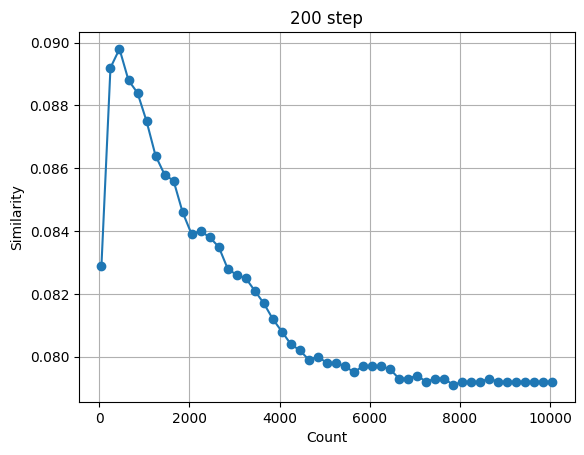

based on Order
450 accuracy: 0.0898


In [75]:
x = [entry[0] for entry in Inv_param_200]
y = [entry[2]['정밀도'] for entry in Inv_param_200]

# 꺾은선 그래프 그리기
plt.plot(x, y, marker='o')

plt.title('200 step')
plt.xlabel('Count')
plt.ylabel('accuracy')

# 그래프 표시
plt.grid(True)
plt.show()

print('based on Order')
print(x[np.argsort(y)[-1]],'accuracy:',max(y))

In [23]:
Inv_param = []

print(recomm_n,'개 추천')
for i in range(400,500):
    pred = predict_count(pivot_IS, get_topsim(sim_Inv, top_n=i), IS = True)
    result = recomm_model(pred, recomm_n=recomm_n)
    Inv_param.append([i,'개의 유사도를 반영할 때',result[3]])

print('최대 정밀도', max(Inv_param, key=lambda x: x[2]['정밀도']))
Inv_param

10 개 추천
최대 정밀도 [437, '개의 유사도를 반영할 때', {'정밀도': 0.0901}]


[[400, '개의 유사도를 반영할 때', {'정밀도': 0.0896}],
 [401, '개의 유사도를 반영할 때', {'정밀도': 0.0898}],
 [402, '개의 유사도를 반영할 때', {'정밀도': 0.0899}],
 [403, '개의 유사도를 반영할 때', {'정밀도': 0.0897}],
 [404, '개의 유사도를 반영할 때', {'정밀도': 0.0897}],
 [405, '개의 유사도를 반영할 때', {'정밀도': 0.0896}],
 [406, '개의 유사도를 반영할 때', {'정밀도': 0.0894}],
 [407, '개의 유사도를 반영할 때', {'정밀도': 0.0894}],
 [408, '개의 유사도를 반영할 때', {'정밀도': 0.0895}],
 [409, '개의 유사도를 반영할 때', {'정밀도': 0.0895}],
 [410, '개의 유사도를 반영할 때', {'정밀도': 0.0898}],
 [411, '개의 유사도를 반영할 때', {'정밀도': 0.0898}],
 [412, '개의 유사도를 반영할 때', {'정밀도': 0.0897}],
 [413, '개의 유사도를 반영할 때', {'정밀도': 0.0898}],
 [414, '개의 유사도를 반영할 때', {'정밀도': 0.0897}],
 [415, '개의 유사도를 반영할 때', {'정밀도': 0.0896}],
 [416, '개의 유사도를 반영할 때', {'정밀도': 0.0894}],
 [417, '개의 유사도를 반영할 때', {'정밀도': 0.0895}],
 [418, '개의 유사도를 반영할 때', {'정밀도': 0.0893}],
 [419, '개의 유사도를 반영할 때', {'정밀도': 0.0895}],
 [420, '개의 유사도를 반영할 때', {'정밀도': 0.0897}],
 [421, '개의 유사도를 반영할 때', {'정밀도': 0.0898}],
 [422, '개의 유사도를 반영할 때', {'정밀도': 0.0899}],
 [423, '개의 유사도를 반영할 때', {'정밀도': 0.

findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Fon

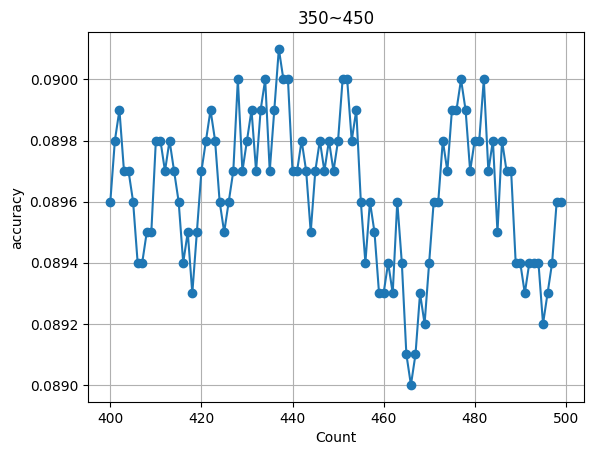

based on Order
437 accuracy: 0.0901


In [76]:
x = [entry[0] for entry in Inv_param]
y = [entry[2]['정밀도'] for entry in Inv_param]

# 꺾은선 그래프 그리기
plt.plot(x, y, marker='o')

plt.title('350~450')
plt.xlabel('Count')
plt.ylabel('accuracy')

# 그래프 표시
plt.grid(True)
plt.show()

print('based on Order')
print(x[np.argsort(y)[-1]],'accuracy:',max(y))

## 고객기반 추천시스템
- 고객의 RFM기반
- value: 구매여부

### RFM 계산, scaling

In [13]:
RFM = train.copy()
RFM['InvoiceDate'] = pd.to_datetime(RFM['InvoiceDate']) #datetime 형식으로 변환
RFM['TotalPrice'] = RFM['Quantity'] * RFM['UnitPrice']

current_date = pd.Timestamp(RFM['InvoiceDate'].max()) + pd.Timedelta(days=1)
df_RFM = RFM.groupby('CustomerID').agg({
    'InvoiceDate' : (lambda x: (current_date - x.max()).days), # R
    'InvoiceNo' : 'count', # F
    'TotalPrice' : 'sum' # M
}) 

RFM_Scaler = MinMaxScaler()
df_RFM_scaled = RFM_Scaler.fit_transform(df_RFM)
df_RFM_scaled = pd.DataFrame(df_RFM_scaled, index =df_RFM.index, columns=df_RFM.columns )


In [28]:
df_RFM_scaled

,InvoiceDate,InvoiceNo,TotalPrice
CustomerID,,,
12346,0.425824,0.004318,0.000522
12347,0.082418,0.007323,0.001898
12348,0.175824,0.003380,0.000683
12349,0.090659,0.018588,0.006908
12351,0.002747,0.003755,0.000932
...,...,...,...
18283,0.021978,0.042997,0.001992
18284,0.156593,0.004882,0.001276
18285,0.785714,0.001878,0.001168


In [14]:
df_CS = pd.DataFrame(train.loc[:,['CustomerID','StockCode']].groupby('CustomerID').value_counts())
df_CS['count'] = 1

pivot_CS = df_CS.pivot_table('count', index='CustomerID',columns='StockCode')
pivot_CS.fillna(0,inplace=True)

sim_Cust = pd.DataFrame(cosine_similarity(df_RFM_scaled),index=df_RFM_scaled.index, columns=df_RFM_scaled.index)

In [27]:
pred_CS = predict_count(pivot_CS, sim_Cust)
result_CS = recomm_model(pred_CS, recomm_n=10)
display(result_CS[2:])

(matrix([[    0, 19289],
         [    0,  1111]]),
 {'정밀도': 0.0545})

In [28]:
pred_CS_top = predict_count(pivot_CS, get_topsim(sim_Cust, top_n=20))
result_CS_top = recomm_model(pred_CS_top, recomm_n=10)
display(result_CS_top[2:])

(matrix([[    0, 19542],
         [    0,   858]]),
 {'정밀도': 0.0421})

In [31]:
Cust_param_100 = []

print(recomm_n,'개 추천')
for i in range(50,3000,100):
    pred = predict_count(pivot_CS, get_topsim(sim_Cust, top_n=i))
    result = recomm_model(pred, recomm_n=recomm_n)
    Cust_param_100.append([i,'개의 유사도를 반영할 때',result[3]])

print('최대 정밀도', max(Cust_param_100, key=lambda x: x[2]['정밀도']))
Cust_param_100

10 개 추천
최대 정밀도 [1050, '개의 유사도를 반영할 때', {'정밀도': 0.0544}]


[[50, '개의 유사도를 반영할 때', {'정밀도': 0.0492}],
 [150, '개의 유사도를 반영할 때', {'정밀도': 0.0529}],
 [250, '개의 유사도를 반영할 때', {'정밀도': 0.0543}],
 [350, '개의 유사도를 반영할 때', {'정밀도': 0.0538}],
 [450, '개의 유사도를 반영할 때', {'정밀도': 0.0543}],
 [550, '개의 유사도를 반영할 때', {'정밀도': 0.0532}],
 [650, '개의 유사도를 반영할 때', {'정밀도': 0.0526}],
 [750, '개의 유사도를 반영할 때', {'정밀도': 0.0533}],
 [850, '개의 유사도를 반영할 때', {'정밀도': 0.0539}],
 [950, '개의 유사도를 반영할 때', {'정밀도': 0.0537}],
 [1050, '개의 유사도를 반영할 때', {'정밀도': 0.0544}],
 [1150, '개의 유사도를 반영할 때', {'정밀도': 0.0538}],
 [1250, '개의 유사도를 반영할 때', {'정밀도': 0.0539}],
 [1350, '개의 유사도를 반영할 때', {'정밀도': 0.0535}],
 [1450, '개의 유사도를 반영할 때', {'정밀도': 0.0534}],
 [1550, '개의 유사도를 반영할 때', {'정밀도': 0.0534}],
 [1650, '개의 유사도를 반영할 때', {'정밀도': 0.0535}],
 [1750, '개의 유사도를 반영할 때', {'정밀도': 0.0535}],
 [1850, '개의 유사도를 반영할 때', {'정밀도': 0.0529}],
 [1950, '개의 유사도를 반영할 때', {'정밀도': 0.0534}],
 [2050, '개의 유사도를 반영할 때', {'정밀도': 0.0528}],
 [2150, '개의 유사도를 반영할 때', {'정밀도': 0.0529}],
 [2250, '개의 유사도를 반영할 때', {'정밀도': 0.0531}],
 [2350, '개의 유사도를 반영할 때

findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Fon

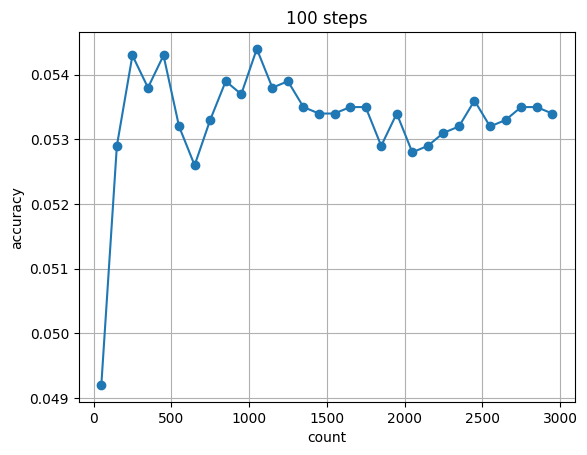

based on Customer
1050 accuracy: 0.0544


In [77]:
x = [entry[0] for entry in Cust_param_100]
y = [entry[2]['정밀도'] for entry in Cust_param_100]

# 꺾은선 그래프 그리기
plt.plot(x, y, marker='o')

plt.title('100 steps')
plt.xlabel('count')
plt.ylabel('accuracy')

# 그래프 표시
plt.grid(True)
plt.show()

print('based on Customer')
print(x[np.argsort(y)[-1]],'accuracy:',max(y))

In [34]:
Cust_param = []

print(recomm_n,'개 추천')
for i in range(1000,1100):
    pred = predict_count(pivot_CS, get_topsim(sim_Cust, top_n=i))
    result = recomm_model(pred, recomm_n=recomm_n)
    Cust_param.append([i,'개의 유사도를 반영할 때',result[3]])

print('최대 정밀도', max(Cust_param, key=lambda x: x[2]['정밀도']))
Cust_param

10 개 추천
최대 정밀도 [1046, '개의 유사도를 반영할 때', {'정밀도': 0.0547}]


[[1000, '개의 유사도를 반영할 때', {'정밀도': 0.054}],
 [1001, '개의 유사도를 반영할 때', {'정밀도': 0.054}],
 [1002, '개의 유사도를 반영할 때', {'정밀도': 0.0542}],
 [1003, '개의 유사도를 반영할 때', {'정밀도': 0.0542}],
 [1004, '개의 유사도를 반영할 때', {'정밀도': 0.0543}],
 [1005, '개의 유사도를 반영할 때', {'정밀도': 0.0543}],
 [1006, '개의 유사도를 반영할 때', {'정밀도': 0.0542}],
 [1007, '개의 유사도를 반영할 때', {'정밀도': 0.0541}],
 [1008, '개의 유사도를 반영할 때', {'정밀도': 0.0539}],
 [1009, '개의 유사도를 반영할 때', {'정밀도': 0.0539}],
 [1010, '개의 유사도를 반영할 때', {'정밀도': 0.0538}],
 [1011, '개의 유사도를 반영할 때', {'정밀도': 0.0539}],
 [1012, '개의 유사도를 반영할 때', {'정밀도': 0.0539}],
 [1013, '개의 유사도를 반영할 때', {'정밀도': 0.0539}],
 [1014, '개의 유사도를 반영할 때', {'정밀도': 0.054}],
 [1015, '개의 유사도를 반영할 때', {'정밀도': 0.0541}],
 [1016, '개의 유사도를 반영할 때', {'정밀도': 0.0542}],
 [1017, '개의 유사도를 반영할 때', {'정밀도': 0.0543}],
 [1018, '개의 유사도를 반영할 때', {'정밀도': 0.0542}],
 [1019, '개의 유사도를 반영할 때', {'정밀도': 0.0539}],
 [1020, '개의 유사도를 반영할 때', {'정밀도': 0.0539}],
 [1021, '개의 유사도를 반영할 때', {'정밀도': 0.0537}],
 [1022, '개의 유사도를 반영할 때', {'정밀도': 0.0538}],
 [1023, '개의 유사

In [15]:
import re
import nltk
from nltk.corpus import stopwords

In [16]:
SD_pairs = train[['StockCode','Description']].groupby('StockCode')['Description'].apply(lambda x: list(set(x))).to_dict()
for stockcode, descriptions in SD_pairs.items(): #리스트형태의 데이터를 문자형으로 변환
    SD_pairs[stockcode] = ' '.join(descriptions)

## 아이템 유사도 기반

In [17]:
SD_pairs = train[['StockCode','Description']].groupby('StockCode')['Description'].apply(lambda x: list(set(x))).to_dict()
for stockcode, descriptions in SD_pairs.items(): #리스트형태의 데이터를 문자형으로 변환
    SD_pairs[stockcode] = ' '.join(descriptions)

Des_uniq = pd.Series(SD_pairs)
Des_uniq = Des_uniq.str.strip()
def replace_slash_with_space(text): #/를 공백으로 치환하는 함수
    return text.replace('/', ' ')
def remove_extra_spaces(text): #공백을 한칸으로 통일
    return re.sub(r'\s+', ' ', text)
Des_uniq = Des_uniq.apply(replace_slash_with_space)
Des_uniq = Des_uniq.apply(remove_extra_spaces)


In [18]:
Des_uniq_split = pd.Series(Des_uniq.str.split(" "))
Des_words = [word for sublist in Des_uniq_split for word in sublist]
uniq_words = set(Des_words)

In [19]:
print('삭제 전 단어 수:',len(uniq_words))

# 영어 불용어 목록
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def remove_special_characters(text): # 문자, 숫자, 공백을 제외한 모든 문자 삭제
    return re.sub(r'[^a-zA-Z0-9\s]', '', text)

uniq_words = {remove_special_characters(word) for word in uniq_words} # 특수 기호 삭제
uniq_words = {word for word in uniq_words if word.strip()} # 공백 또는 빈 문자열 삭제
uniq_words = {word for word in uniq_words if not word.isdigit()} #숫자 삭제
uniq_words -= stop_words # 불용어 삭제

print('삭제 후 단어 수:',len(uniq_words))

삭제 전 단어 수: 2265
삭제 후 단어 수: 2154


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kimminji/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [20]:
df_Des = pd.DataFrame()
for word in uniq_words:
    pattern = r'(\b{}\b|^\w+ {}\b|\b{} \w+$)'.format(word, word, word) # 공백이나 문장부호와 함께 등장하는 단어를 포함하는 정규표현식

    # 정규표현식을 사용하여 해당 단어가 Description에 포함되어 있는지 여부를 확인
    df_Des[word] = Des_uniq.str.contains(pattern, regex=True).astype(int)

sim_Des = pd.DataFrame(cosine_similarity(df_Des),index=df_Des.index, columns=df_Des.index)

In [67]:
Item_param_100 = []

print(recomm_n,'개 추천')
for i in range(50,4001,100):
    sim = get_topsim(sim_Des, top_n= i)
    pred = pivot_CS.values.dot(sim.values) / np.array([np.abs(sim.values).sum(axis=1)])
    pred = pd.DataFrame(pred, index=pivot_CS.index, columns=pivot_CS.columns)
    result = recomm_model(pred, recomm_n=recomm_n)
    Item_param_100.append([i,'개의 유사도를 반영할 때',result[3]])

print('최대 정밀도',max(Item_param_100, key=lambda x: x[2]['정밀도']))
Item_param_100

10 개 추천
최대 정밀도 [450, '개의 유사도를 반영할 때', {'정밀도': 0.0347}]


[[50, '개의 유사도를 반영할 때', {'정밀도': 0.0272}],
 [150, '개의 유사도를 반영할 때', {'정밀도': 0.0238}],
 [250, '개의 유사도를 반영할 때', {'정밀도': 0.0272}],
 [350, '개의 유사도를 반영할 때', {'정밀도': 0.0326}],
 [450, '개의 유사도를 반영할 때', {'정밀도': 0.0347}],
 [550, '개의 유사도를 반영할 때', {'정밀도': 0.0347}],
 [650, '개의 유사도를 반영할 때', {'정밀도': 0.0343}],
 [750, '개의 유사도를 반영할 때', {'정밀도': 0.0343}],
 [850, '개의 유사도를 반영할 때', {'정밀도': 0.0342}],
 [950, '개의 유사도를 반영할 때', {'정밀도': 0.0343}],
 [1050, '개의 유사도를 반영할 때', {'정밀도': 0.0343}],
 [1150, '개의 유사도를 반영할 때', {'정밀도': 0.0343}],
 [1250, '개의 유사도를 반영할 때', {'정밀도': 0.0343}],
 [1350, '개의 유사도를 반영할 때', {'정밀도': 0.0343}],
 [1450, '개의 유사도를 반영할 때', {'정밀도': 0.0343}],
 [1550, '개의 유사도를 반영할 때', {'정밀도': 0.0343}],
 [1650, '개의 유사도를 반영할 때', {'정밀도': 0.0343}],
 [1750, '개의 유사도를 반영할 때', {'정밀도': 0.0343}],
 [1850, '개의 유사도를 반영할 때', {'정밀도': 0.0343}],
 [1950, '개의 유사도를 반영할 때', {'정밀도': 0.0343}],
 [2050, '개의 유사도를 반영할 때', {'정밀도': 0.0343}],
 [2150, '개의 유사도를 반영할 때', {'정밀도': 0.0343}],
 [2250, '개의 유사도를 반영할 때', {'정밀도': 0.0343}],
 [2350, '개의 유사도를 반영할 때

findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.


findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Fon

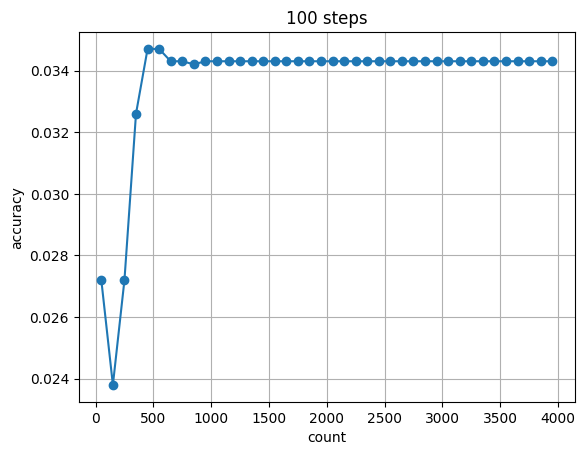

based on Items
450 accuracy: 0.0347


In [78]:
x = [entry[0] for entry in Item_param_100]
y = [entry[2]['정밀도'] for entry in Item_param_100]

# 꺾은선 그래프 그리기
plt.plot(x, y, marker='o')

plt.title('100 steps')
plt.xlabel('count')
plt.ylabel('accuracy')

# 그래프 표시
plt.grid(True)
plt.show()

print('based on Items')
print(x[np.argsort(y)[-1]],'accuracy:',max(y))

In [70]:
Item_param = []

print(recomm_n,'개 추천')
for i in range(400,501):
    sim = get_topsim(sim_Des, top_n= i)
    pred = pivot_CS.values.dot(sim.values) / np.array([np.abs(sim.values).sum(axis=1)])
    pred = pd.DataFrame(pred, index=pivot_CS.index, columns=pivot_CS.columns)
    result = recomm_model(pred, recomm_n=recomm_n)
    Item_param.append([i,'개의 유사도를 반영할 때',result[3]])
    
print('최대 유사도',max(Item_param, key=lambda x: x[2]['정밀도']))
Item_param

10 개 추천
최대 유사도 [439, '개의 유사도를 반영할 때', {'정밀도': 0.0349}]


[[400, '개의 유사도를 반영할 때', {'정밀도': 0.0345}],
 [401, '개의 유사도를 반영할 때', {'정밀도': 0.0345}],
 [402, '개의 유사도를 반영할 때', {'정밀도': 0.0345}],
 [403, '개의 유사도를 반영할 때', {'정밀도': 0.0345}],
 [404, '개의 유사도를 반영할 때', {'정밀도': 0.0345}],
 [405, '개의 유사도를 반영할 때', {'정밀도': 0.0346}],
 [406, '개의 유사도를 반영할 때', {'정밀도': 0.0345}],
 [407, '개의 유사도를 반영할 때', {'정밀도': 0.0345}],
 [408, '개의 유사도를 반영할 때', {'정밀도': 0.0345}],
 [409, '개의 유사도를 반영할 때', {'정밀도': 0.0345}],
 [410, '개의 유사도를 반영할 때', {'정밀도': 0.0345}],
 [411, '개의 유사도를 반영할 때', {'정밀도': 0.0346}],
 [412, '개의 유사도를 반영할 때', {'정밀도': 0.0345}],
 [413, '개의 유사도를 반영할 때', {'정밀도': 0.0346}],
 [414, '개의 유사도를 반영할 때', {'정밀도': 0.0345}],
 [415, '개의 유사도를 반영할 때', {'정밀도': 0.0345}],
 [416, '개의 유사도를 반영할 때', {'정밀도': 0.0345}],
 [417, '개의 유사도를 반영할 때', {'정밀도': 0.0345}],
 [418, '개의 유사도를 반영할 때', {'정밀도': 0.0346}],
 [419, '개의 유사도를 반영할 때', {'정밀도': 0.0345}],
 [420, '개의 유사도를 반영할 때', {'정밀도': 0.0345}],
 [421, '개의 유사도를 반영할 때', {'정밀도': 0.0345}],
 [422, '개의 유사도를 반영할 때', {'정밀도': 0.0346}],
 [423, '개의 유사도를 반영할 때', {'정밀도': 0.

## 종합모델

In [21]:
pred_IS = predict_count(pivot_IS, get_topsim(sim_Inv, top_n = 437), IS = True)
pred_CS = predict_count(pivot_CS, get_topsim(sim_Cust, top_n = 1050))

topsim_Des = get_topsim(sim_Des, top_n= 439)
pred_Des = pivot_CS.values.dot(topsim_Des.values) / np.array([np.abs(topsim_Des.values).sum(axis=1)])
pred_Des = pd.DataFrame(pred_Des, index=pivot_CS.index, columns=pivot_CS.columns)

In [72]:
print(recomm_model(pred_IS, recomm_n = recomm_n)[3])
print(recomm_model(pred_CS, recomm_n = recomm_n)[3])
print(recomm_model(pred_Des, recomm_n = recomm_n)[3])

{'정밀도': 0.0901}
{'정밀도': 0.0544}
{'정밀도': 0.0349}


In [73]:
total_param = [] 

# 첫 번째 숫자 선택
for num1 in range(101): #2601번 실행
    # 두 번째 숫자 선택
    for num2 in range(num1 + 1):
        # 세 번째 숫자는 첫 번째와 두 번째 숫자를 뺀 나머지
        num3 = 100 - num1 - num2
        # 세 번째 숫자가 음수가 되면 다음 순서로 넘어감
        if num3 < 0:
            continue

        num_1 = num1/100
        num_2 = num2/100
        num_3 = num3/100

        precision = recomm_model((num_1*pred_IS + num_2*pred_CS + num_3*pred_Des), recomm_n = recomm_n)[3]
        total_param.append(['가중치 비율',[num_1, num_2, num_3], precision])

        print('가중치 비율',[num_1, num_2, num_3], precision)
        
print('\n 최대 정밀도:', max(total_param, key=lambda x: x[2]['정밀도']))

가중치 비율 [0.0, 0.0, 1.0] {'정밀도': 0.0349}
가중치 비율 [0.01, 0.0, 0.99] {'정밀도': 0.0352}
가중치 비율 [0.01, 0.01, 0.98] {'정밀도': 0.0355}
가중치 비율 [0.02, 0.0, 0.98] {'정밀도': 0.0355}
가중치 비율 [0.02, 0.01, 0.97] {'정밀도': 0.0358}
가중치 비율 [0.02, 0.02, 0.96] {'정밀도': 0.0363}
가중치 비율 [0.03, 0.0, 0.97] {'정밀도': 0.0362}
가중치 비율 [0.03, 0.01, 0.96] {'정밀도': 0.0365}
가중치 비율 [0.03, 0.02, 0.95] {'정밀도': 0.0369}
가중치 비율 [0.03, 0.03, 0.94] {'정밀도': 0.0373}
가중치 비율 [0.04, 0.0, 0.96] {'정밀도': 0.0365}
가중치 비율 [0.04, 0.01, 0.95] {'정밀도': 0.0368}
가중치 비율 [0.04, 0.02, 0.94] {'정밀도': 0.0374}
가중치 비율 [0.04, 0.03, 0.93] {'정밀도': 0.0376}
가중치 비율 [0.04, 0.04, 0.92] {'정밀도': 0.0379}
가중치 비율 [0.05, 0.0, 0.95] {'정밀도': 0.0371}
가중치 비율 [0.05, 0.01, 0.94] {'정밀도': 0.0375}
가중치 비율 [0.05, 0.02, 0.93] {'정밀도': 0.0379}
가중치 비율 [0.05, 0.03, 0.92] {'정밀도': 0.0379}
가중치 비율 [0.05, 0.04, 0.91] {'정밀도': 0.0382}
가중치 비율 [0.05, 0.05, 0.9] {'정밀도': 0.0387}
가중치 비율 [0.06, 0.0, 0.94] {'정밀도': 0.0375}
가중치 비율 [0.06, 0.01, 0.93] {'정밀도': 0.0377}
가중치 비율 [0.06, 0.02, 0.92] {'정밀도': 0.038}
가중치

findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.


findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Fon

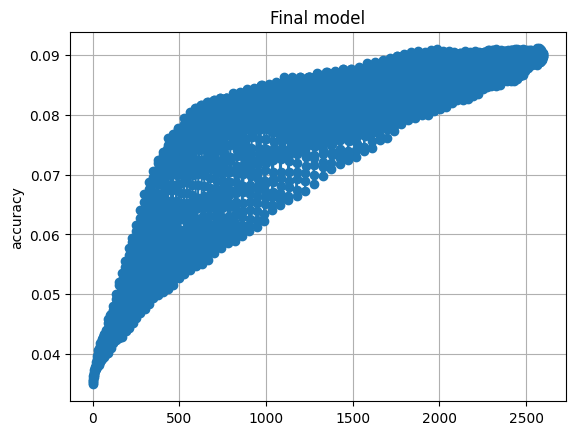

최대 정밀도 0.0911


In [81]:
x = range(len(total_param))
y = [entry[2]['정밀도'] for entry in total_param]

# 꺾은선 그래프 그리기
plt.plot(x, y, marker='o')

plt.title('Final model')
plt.xlabel('')
plt.ylabel('accuracy')

# 그래프 표시
plt.grid(True)
plt.show()

print('최대 정밀도',max(y))

## 모델 검증

In [22]:
#구매 수량 순, 구매 횟수 순 정렬
top_Quant_prod = train[['StockCode','Quantity']].groupby('StockCode').sum().sort_values(by='Quantity',ascending=False)
top_buy_prod = pd.DataFrame(train['StockCode'].value_counts())

In [23]:
def popular_prod_eval(recomm_n = 10, popular_df = top_Quant_prod):
    total_conf_matrix = np.matrix([[0,0],[0,0]])
    shared_customers = set(train['CustomerID'].unique()).intersection(set(test['CustomerID'].unique())) 
    for CustomerID in shared_customers:
        #구매하지 않은 상품 추출
        Customer_info = pivot_CS.loc[CustomerID,]
        unbought_list = Customer_info[Customer_info==0].index

        #구매하지 않은 상품 중 상위 인기 recomm_n개 추천
        unbought_pop_df = popular_df[popular_df.index.isin(unbought_list)]
        recomm_prod = unbought_pop_df[:recomm_n].index

        #평가
        y_test = pd.Series(np.zeros(recomm_n))
        for index, value in enumerate(recomm_prod):
            if value in pivot_test.columns:
                y_test[index] = pivot_test.loc[CustomerID, value]
        y_pred = pd.Series(np.ones(len(recomm_prod)))
        conf_matrix = confusion_matrix(y_test, y_pred) # 혼동 행렬 계산
        if (conf_matrix[0,0] != 0):
            print('<전부 구매함>', f'\nCustomerID: {CustomerID}', f'\nprodcuct: {recomm_prod}')
            total_conf_matrix = total_conf_matrix + [[0,0],[0,conf_matrix[0,0]]]
        else:
            total_conf_matrix = total_conf_matrix + conf_matrix

    FP = total_conf_matrix[0,1]
    TP = total_conf_matrix[1,1]

    precision = np.round(TP / (TP + FP), 4) # 정밀도 계산

    evaluation = {'정밀도': precision}    
    return total_conf_matrix, evaluation

### 인기순 정밀도

In [25]:
recomm_n = 10

print(popular_prod_eval(recomm_n=recomm_n,popular_df=top_Quant_prod))
popular_prod_eval(recomm_n=recomm_n,popular_df=top_buy_prod)

(matrix([[    0, 19651],
        [    0,   749]]), {'정밀도': 0.0367})


(matrix([[    0, 19376],
         [    0,  1024]]),
 {'정밀도': 0.0502})

In [36]:
pred_final = recomm_model((0.93*pred_IS + 0*pred_CS + 0.07*pred_Des), recomm_n = recomm_n)
recomm_final = pred_final[1]

In [34]:
def recomm_test(CustomerID):
    recomm_SC = recomm_final[recomm_final['CustomerID'] == CustomerID[0]]['recommend_products'].explode().tolist()
    recomm_Des = pairs_SD[pairs_SD.index.isin(recomm_SC)]
    recomm_Des.name = 'recomm_prod'
    
    bought_SC = train[train['CustomerID'] == CustomerID[0]]['StockCode'].unique()
    bought_Des = pairs_SD[pairs_SD.index.isin(bought_SC)]
    bought_Des.name = 'bought_prod'

    new_bought_SC = test[test['CustomerID'] == CustomerID[0]]['StockCode'].unique()
    new_bought_Des = pairs_SD[pairs_SD.index.isin(new_bought_SC)]
    new_bought_Des.name = 'new_bought_prod'

    bought_from_recomm = recomm_Des[recomm_Des.isin(new_bought_Des)]
    bought_from_recomm.name = 'bought_from_recomm'
    return recomm_Des, bought_Des, new_bought_Des, bought_from_recomm

## 추천 내역 예시

In [42]:
import random

# random.seed(1004)
test_ID = random.sample(recomm_final['CustomerID'].tolist(), 1)
print('CustomerID:',test_ID,'\n')

model_test = recomm_test(test_ID) 

print(model_test[0],'\n') #추천제품
print(model_test[1],'\n') #기존 구매 제품
print(model_test[2],'\n') #최근 구매 제품
print(model_test[3]) #추천한 제품 중 구매한 제품

CustomerID: [17968] 

StockCode
20725                   [LUNCH BAG RED SPOTTY]
21094          [SET/6 RED SPOTTY PAPER PLATES]
21122       [SET/10 PINK SPOTTY PARTY CANDLES]
21124       [SET/10 BLUE SPOTTY PARTY CANDLES]
21212       [PACK OF 72 RETRO SPOT CAKE CASES]
22383                 [LUNCHBAG SUKI  DESIGN ]
22384                [LUNCHBAG PINK RETROSPOT]
22952        [72 CAKE CASES VINTAGE CHRISTMAS]
85099B           [JUMBO BAG RED WHITE SPOTTY ]
85123A    [WHITE HANGING HEART T-LIGHT HOLDER]
Name: recomm_prod, dtype: object 

StockCode
10123G                [ARMY CAMO WRAPPING TAPE]
20727                 [LUNCH BAG  BLACK SKULL.]
20931                  [BLUE POT PLANT CANDLE ]
21080        [SET/20 RED SPOTTY PAPER NAPKINS ]
21086             [SET/6 RED SPOTTY PAPER CUPS]
21121         [SET/10 RED SPOTTY PARTY CANDLES]
21425                [SKULLS STORAGE BOX LARGE]
21562                   [HAWAIIAN GRASS SKIRT ]
21609     [SET 12 LAVENDER  BOTANICAL T-LIGHTS]
21610          [SET 1

In [43]:
print(model_test[3]) #추천한 제품 중 구매한 제품

StockCode
21122     [SET/10 PINK SPOTTY PARTY CANDLES]
21124     [SET/10 BLUE SPOTTY PARTY CANDLES]
21212     [PACK OF 72 RETRO SPOT CAKE CASES]
22952      [72 CAKE CASES VINTAGE CHRISTMAS]
85099B         [JUMBO BAG RED WHITE SPOTTY ]
Name: bought_from_recomm, dtype: object
